[22103.0361054, 32061.3492823, 8039.68044526, 17443.5305466, 13375.5092745, 44482] [617.11011058306644, 897.67776648129131, 222.74486318523557, 488.66361669804763, 372.55884025342209, 1241.7848057552901] [-4.930325428449283, 8.1737920365223236, 2.6216706271046331, 5.6194367948188333, 3.2873332257505354, -5.4747361202718849]
                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.892e+05
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.68e-10
Time:                        16:30:36   Log-Likelihood:                -32.517
No. Observations:                   6   AIC:                             69.03
Df Residuals:                       4   BIC:                             68.62
Df Model:                           1     

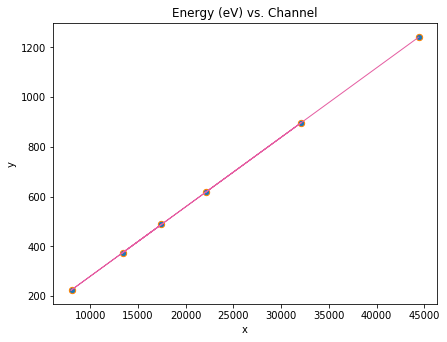

([148.6708986500048, 179.05683254849563, 89.664265152066008, 132.07395862394677, 115.65253682691097, 210.90756269038812], [-0.59336504044052418, 0.81677986270830194, 0.52315583128212817, 0.76128615472343819, 0.5085819019102682, -0.46445471287217188])
                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.394e+04
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.09e-08
Time:                        16:30:36   Log-Likelihood:                 1.6447
No. Observations:                   6   AIC:                            0.7106
Df Residuals:                       4   BIC:                            0.2941
Df Model:                           1                                         
Covariance Type:            nonrobust 

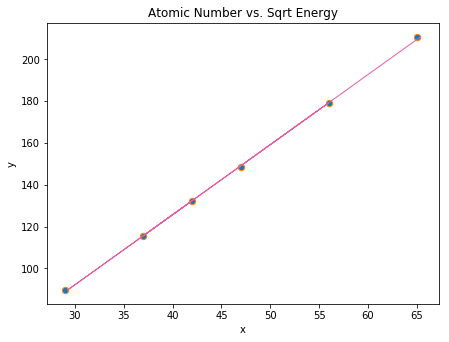

0    47
1    56
2    29
3    42
4    37
5    65
Name: x, dtype: int64 0    148.670899
1    179.056833
2     89.664265
3    132.073959
4    115.652537
5    210.907563
Name: y, dtype: float64 2.54705046345


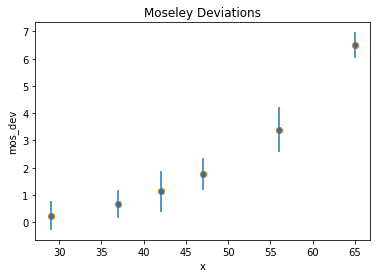

slope: 3.35543341618 0.0284203711853
intercept: -8.54645823777 -1.29319552717
a: 2.54705046345 0.386006749782


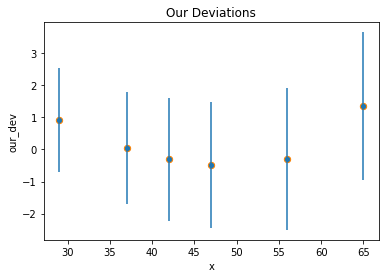

In [66]:
%matplotlib inline
import pandas
import numpy as np

import matplotlib.pyplot as plt
import analysis
reload(analysis)

ranges = [(580, 660), (850, 950), (220, 240), \
          (470, 525), (360, 400), (1230, 1255)]
energies = [22103.0361054, 32061.3492823, 8039.68044526, \
            17443.5305466, 13375.5092745, 44482]

calibration_files = ['Ag_9NOV.csv', 'Ba_9NOV.csv', 'Cu_09NOV.csv', \
                     'Mo_9NOV.csv', 'Rb_9NOV.csv', 'Tb_9NOV.csv']

atomic_numbers = [47, 56, 29, 42, 37, 65]

data = []
means = []
stds = []

for index, calibration in enumerate(calibration_files):
    data = pandas.read_csv('data/' + calibration)
    a, mean, std = analysis.find_gaussian(data, ranges[index])
    means.append(mean)
    stds.append(std)
    data['Fit'] = data['Channel'].apply(lambda chan: analysis.gauss_function(chan, a, mean, std))
    
chan_params = analysis.find_regression(energies, means, stds)
wls_fit = chan_params[2]
print(wls_fit.summary())
ws = chan_params[3]

y = chan_params[0][0]
intercept = chan_params[0][1]

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ax_fit = ws.plot(
    kind='scatter',
    x='x',
    y='y',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='Energy (eV) vs. Channel',
    edgecolor='#ff8300',
    s=40
)

# weighted prediction
wp, = ax.plot(
    wls_fit.predict(),
    ws['y'],
    color='#e55ea2',
    lw=1.,
    alpha=1.0,
)

plt.tight_layout()
fig.set_size_inches(6.40, 5.12)
plt.savefig("energy_fit.png", dpi=100, alpha=True)
plt.show()

#energy_means = map(lambda x: y*x + intercept, means)
energy_means = energies
energy_stds = map(lambda x: y*x, stds)
relative_error = map(lambda x: x[1]/x[0], zip(energy_means, energy_stds))
sqrt_energies = map(lambda x: np.sqrt(x), energy_means)
sqrt_energies_error = map(lambda x: x[0]*(x[1]/2), zip(sqrt_energies, relative_error))
print(sqrt_energies, sqrt_energies_error)

mos_params = analysis.find_regression_inverse(atomic_numbers, sqrt_energies, sqrt_energies_error)
wls_fit = mos_params[2]
print(wls_fit.summary())
ws = mos_params[3]

mos_y = mos_params[0][0]
mos_intercept = mos_params[0][1]
mos_y_err = mos_params[1][0]
mos_intercept_err = mos_params[1][1]
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ax_fit = ws.plot(
    kind='scatter',
    x='x',
    y='y',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='Atomic Number vs. Sqrt Energy',
    edgecolor='#ff8300',
    s=40
)

# weighted prediction
wp, = ax.plot(
    wls_fit.predict(),
    ws['y'],
    color='#e55ea2',
    lw=1.,
    alpha=1.0,
)

plt.tight_layout()
fig.set_size_inches(6.40, 5.12)
plt.savefig("atomic_number_fit.png", dpi=100, alpha=True)
plt.show()

slope = 1/mos_y
slope_err = mos_y_err/mos_y*slope
intercept = -1*mos_intercept/mos_y
intercept_err = np.sqrt((mos_y_err/mos_y)**2 + (mos_intercept_err/mos_intercept)**2)*intercept

a = -1*intercept/slope
a_err = np.sqrt((intercept_err/intercept)**2 + (slope_err/slope)**2)*a

ws['mos_fit'] = ws['x'].apply(lambda x:np.sqrt(10.2)*(x-1))
ws['fit'] = ws['x'].apply(lambda x:x*slope+intercept)
ws['fit_err'] = ws['x'].apply(lambda x:(np.sqrt((slope_err*x)**2 + intercept_err**2)))
ws['mos_dev'] = ws['y'] - ws['mos_fit']
ws['our_dev'] = ws['y'] - ws['fit']
print ws['x'], ws['y'], mos_intercept
ws['our_dev_err'] = list(map(lambda t: np.sqrt(t[0]**2 + t[1]**2), zip(ws['yerr'], ws['fit_err'])))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ax_fit = ws.plot(
    kind='scatter',
    x='x',
    y='mos_dev',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='Moseley Deviations',
    edgecolor='#ff8300',
    s=40
)
plt.show()

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ax_fit = ws.plot(
    kind='scatter',
    x='x',
    y='our_dev',
    yerr='our_dev_err',
    style='o',
    alpha=1.,
    ax=ax,
    title='Our Deviations',
    edgecolor='#ff8300',
    s=40
)

print 'slope:', slope, slope_err
print 'intercept:', intercept, intercept_err
print 'a:', a, a_err